In [1]:
'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# Define models and variables to plot
models = ['yopp','gfdlsipn']
runType = 'forecast'
variables = ['hi', 'sic']

In [3]:
weeks = pd.to_timedelta(np.arange(0,5,1), unit='W')
months = pd.to_timedelta(np.arange(2,12,1), unit='M')
years = pd.to_timedelta(np.arange(1,2), unit='Y') - np.timedelta64(1, 'D') # need 364 not 365
slices = weeks.union(months).union(years).round('1d')

All models merged...
Starting plots...


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_00.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_01.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_02.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_03.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_04.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_05.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/hi/maps/panArctic_EnsembleMean_forecast_2018-03-01-00:00_06.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



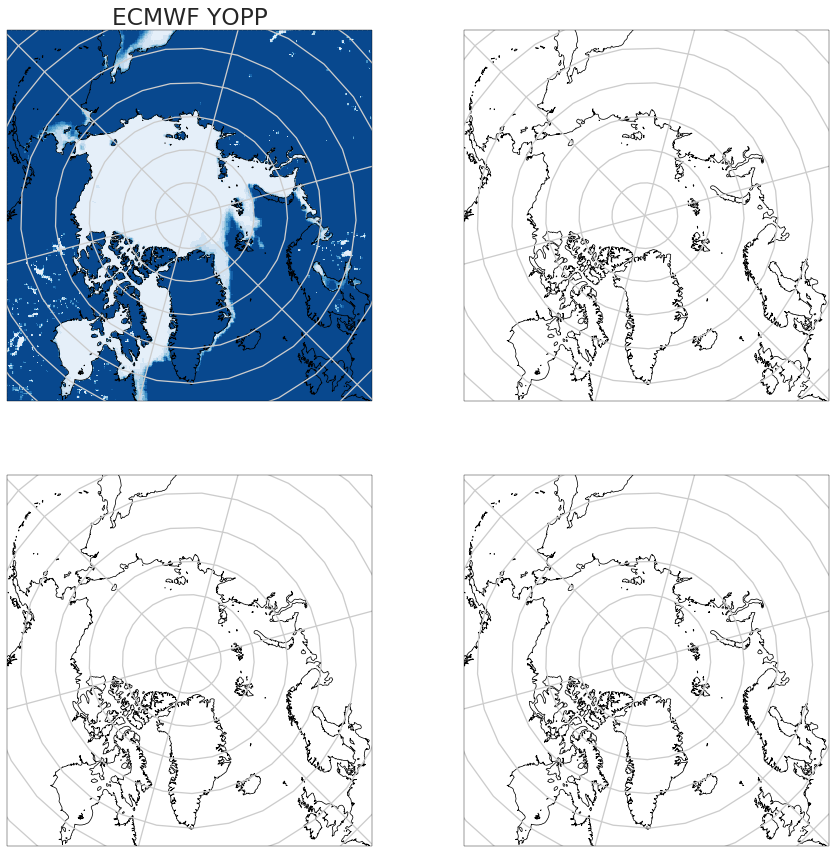

In [4]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

for cvar in variables:

    ds_mm_l = []
    for c_model in models:

        # Load in Model
        model_forecast = os.path.join(E.model[c_model][runType]['sipn_nc'], '*.nc')
        ds_model = xr.open_mfdataset(model_forecast)
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

        # Set attributes
        ds_model.attrs['model_label'] = E.model[c_model]['model_label']
        ds_model.attrs['model_grid_file'] = E.model[c_model]['grid']
        ds_model.attrs['stero_grid_file'] = E.obs['NSIDC_0051']['grid']

        # Select var of interest (if available)
        if cvar in ds_model.variables:
            ds_model = ds_model[cvar]
        else:
            continue
            
        # Average over ensembles (if available)
        ds_model = ds_model.mean(dim='ensemble')

        # Set new dim model
        ds_model.coords['model'] = c_model
        ds_mm_l.append(ds_model)

    # Concat
    ds_mm = xr.concat(ds_mm_l, dim='model')
    print("All models merged...")

    #############################################################

    # ds_mm.fore_time.values.astype('timedelta64[D]')

    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "maps")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # Set up plotting info
    if cvar=='sic':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif cvar=='hi':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
    else:
        raise ValueError("cvar not found.")
            

    # Plot sea ice concentration MAPS 
    # Most recent initialization time
    # From ensemble mean (if ensemble availble)
    # For select forecast times
    #slices = pd.to_timedelta([0, 1 ,2 ,3 ,4*1, 4*2, 4*3, 4*4, 4*5, 4*6, 4*7, 4*8, 4*9, 4*10, 4*11, 4*12], unit='W')
    

    
    print("Starting plots...")
    for it in [ds_mm.init_time[0]]:
        print("WARNING: only plotting first init_time.")

        for (cs, ft) in enumerate(slices): 
            cs_str = format(cs, '02')
            
            c_da = ds_mm.sel(init_time=it).sel(fore_time=ft)

            (f, axes) = esio.multi_polar_axis(ncols=2, nrows=2)
            for (i, cmod) in enumerate(c_da.model):

                # Plot
                p = c_da.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
                axes[i].set_title(E.model[cmod.model.item(0)]['model_label'])
            
            f.subplots_adjust(right=0.8)
            cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
            f.colorbar(p, cax=cbar_ax, label=c_label)

            # Set title of all plots
            init_time =  pd.to_datetime( c_da.init_time.values).strftime('%Y-%m-%d-%H:%M')
            valid_time = pd.to_datetime( c_da.init_time.values + c_da.fore_time.values ).strftime('%Y-%m-%d-%H:%M')
            plt.suptitle('Initialization Time: '+init_time+'\n Valid Time: '+valid_time, fontsize=20)
            # Save to file
            f_out = os.path.join(fig_dir,'panArctic_EnsembleMean_'+runType+'_'+init_time+'_'+cs_str+'.png')
            f.savefig(f_out,bbox_inches='tight',dpi=200)
            print("saved ", f_out)
            # Mem clean up
            plt.close(f)
            c_da = None

In [ ]:
# weeks = pd.to_timedelta(np.arange(0,5,1), unit='W')
# months = pd.to_timedelta(np.arange(2,12,1), unit='M')
# years = pd.to_timedelta(np.arange(1,2), unit='Y') - np.timedelta64(1, 'D')
# weeks.union(months).union(years).round('1d')

In [ ]:
# ds_mm.fore_time.values.astype('timedelta64[D]')

In [ ]:
# import pandas as pd
# import numpy as np
# weeks = pd.to_timedelta(np.arange(0,4,1), unit='W')
# months = pd.to_timedelta(np.arange(2,7,1), unit='M')
# years = pd.to_timedelta(np.arange(1,2), unit='Y')
# slices = weeks.union(months).union(years).round('1d')
# slices

In [ ]:
# np.datetime64('2018-03-01') + slices